<a href="https://colab.research.google.com/github/MeikoFudo/Brain-Tumor-Segmentation/blob/develop/Brain_Tumor_Segmentation_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'lgg-mri-segmentation:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F181273%2F407317%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240820%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240820T041203Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8275c78a2727b335c10c9c2b9ce9f03656a0f5428adfab0fcc7ed42bb40e0f69b23721b0ee4357802c4f4f2fdca197e43df39752866b2ddfd1b9ed1bf97777c6c3f438dd76c57b1e3c59b6939701a4f0b6a04bc2c614a1295faa01c4449df79bf9cbb48a8aec6aa58924c273fca08537fc5d5ed41fa84c470a1406eb624d6ef27dfc0f149e411b918370df93c5d90955e573f550a6598009b63b2626d4bd22737eaf011a12216f577b1d8e79cbde8d10adedb42488e88ae231b1b04d64dce7654bc7180fd600168b7937f7e0eb0cdadccacc50c1b0b9a03d140e7297ee85dd6e57e502ae49524972f20abc78d88e6d87020169049e9c6bc860b5be71d964eb1b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


# Loading data

In [ ]:
import os
import random
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras import Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import (
    Activation, BatchNormalization, Dropout, Lambda,
    Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

plt.style.use("ggplot")
%matplotlib inline

warnings.filterwarnings('ignore')


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
EPOCHS = 35
BATCH_SIZE = 32
IMGHEIGHT = 224
IMGWIDTH = 224
CHANNELS = 3
IMG_WIDTH = 224
IMG_HEIGHT = 224
CHANNELS = 3

In [ ]:
directory = []
image_files = []
mask_files = []
for dirname, _, filenames in os.walk('/kaggle/input/lgg-mri-segmentation/kaggle_3m/'):
    for filename in filenames:
        if 'mask'in filename:
            directory.append(dirname.replace('/kaggle/input/lgg-mri-segmentation/kaggle_3m/', ''))
            mask_files.append(filename)
            image_files.append(filename.replace('_mask', ''))

In [ ]:
print(f"{directory[0]}\n{image_files[0]}\n{mask_files[0]}")

TCGA_DU_7010_19860307
TCGA_DU_7010_19860307_56.tif
TCGA_DU_7010_19860307_56_mask.tif


In [ ]:
samples_df = pd.DataFrame({'directory':directory, 'images': image_files, 'masks': mask_files})

In [ ]:
samples_df.sample()

,directory,images,masks
2319,TCGA_FG_5962_20000626,TCGA_FG_5962_20000626_7.tif,TCGA_FG_5962_20000626_7_mask.tif


In [ ]:
samples_df.shape[0]

3929

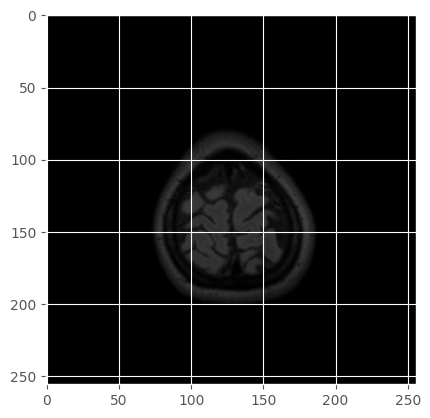

In [ ]:
idx = random.randint(0, len(samples_df))
image_path = os.path.join('/kaggle/input/lgg-mri-segmentation/kaggle_3m/', samples_df['directory'].iloc[idx], samples_df['images'].iloc[idx])
mask_path = os.path.join('/kaggle/input/lgg-mri-segmentation/kaggle_3m/', samples_df['directory'].iloc[idx], samples_df['masks'].iloc[idx])
img = cv2.imread(image_path)
msk = cv2.imread(mask_path)
plt.imshow(img)
plt.imshow(msk, alpha=0.3)

In [ ]:
img = cv2.imread(image_path)
msk = cv2.imread(mask_path)
print(f"Image Shape: {img.shape}\nMask Shape: {msk.shape}")

Image Shape: (256, 256, 3)
Mask Shape: (256, 256, 3)


In [ ]:
def print_image_info(image_path):
    img = cv2.imread(image_path)

    if img is None:
        print("Failed to load image.")
        return

    height, width, channels = img.shape
    total_pixels = height * width
    dtype = img.dtype

    if channels == 1:
        color_encoding = "Grayscale"
    elif channels == 3:
        color_encoding = "RGB"
    else:
        color_encoding = "Unknown"

    print(f"Image Path: {image_path}")
    print('-'*80)
    print(f"Image Size: {width}x{height} pixels")
    print('-'*80)
    print(f"Total Pixels: {total_pixels}")
    print('-'*80)
    print(f"Number of Channels: {channels}")
    print('-'*80)
    print(f"Color Encoding: {color_encoding}")
    print('-'*80)
    print(f"Pixel Type: {dtype}")

idx = random.randint(0, len(samples_df) - 1)
image_path = os.path.join('/kaggle/input/lgg-mri-segmentation/kaggle_3m/', samples_df['directory'].iloc[idx], samples_df['images'].iloc[idx])
mask_path = os.path.join('/kaggle/input/lgg-mri-segmentation/kaggle_3m/', samples_df['directory'].iloc[idx], samples_df['masks'].iloc[idx])

print_image_info(image_path)
print_image_info(mask_path)


Image Path: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_17.tif
--------------------------------------------------------------------------------
Image Size: 256x256 pixels
--------------------------------------------------------------------------------
Total Pixels: 65536
--------------------------------------------------------------------------------
Number of Channels: 3
--------------------------------------------------------------------------------
Color Encoding: RGB
--------------------------------------------------------------------------------
Pixel Type: uint8
Image Path: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_17_mask.tif
--------------------------------------------------------------------------------
Image Size: 256x256 pixels
--------------------------------------------------------------------------------
Total Pixels: 65536
----------------------------------------------------------

In [ ]:
def plotImages():
    idx = np.random.randint(0, len(samples_df))

    imagePath = os.path.join('/kaggle/input/lgg-mri-segmentation/kaggle_3m/', samples_df['directory'].iloc[idx], samples_df['images'].iloc[idx])
    maskPath = os.path.join('/kaggle/input/lgg-mri-segmentation/kaggle_3m/', samples_df['directory'].iloc[idx], samples_df['masks'].iloc[idx])

    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)

    fig, axs = plt.subplots(1,3, figsize=[13,15])

    axs[0].imshow(image)
    axs[0].set_title('Brain MRI')

    axs[1].imshow(mask)
    axs[1].set_title('Mask')

    axs[2].imshow(image)
    axs[2].imshow(mask, alpha=0.3)
    axs[2].set_title('MRI with mask')

    plt.grid(False)
    plt.show()

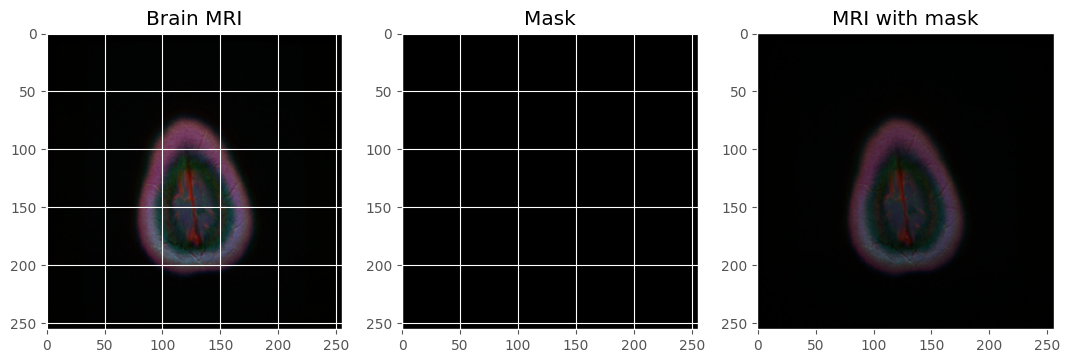

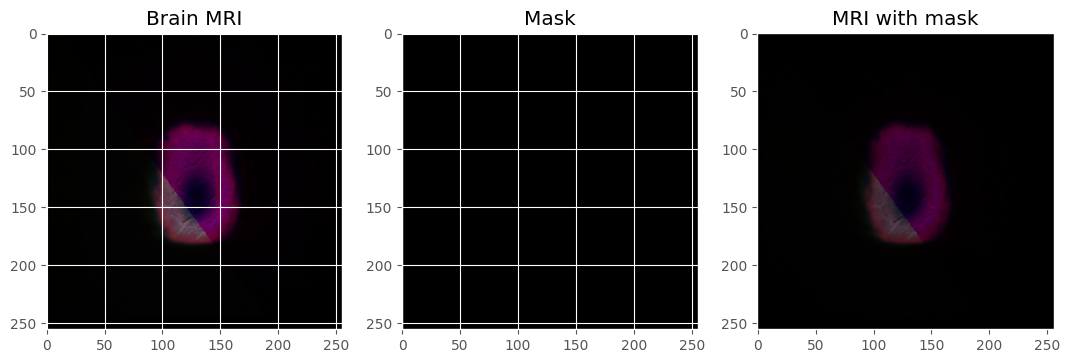

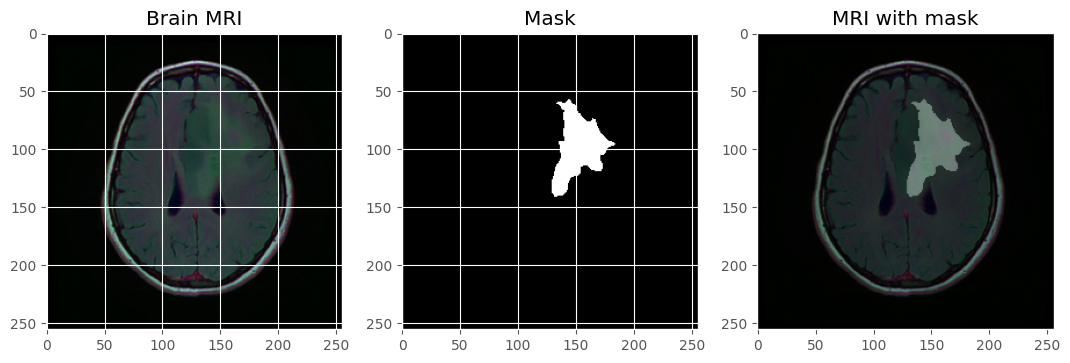

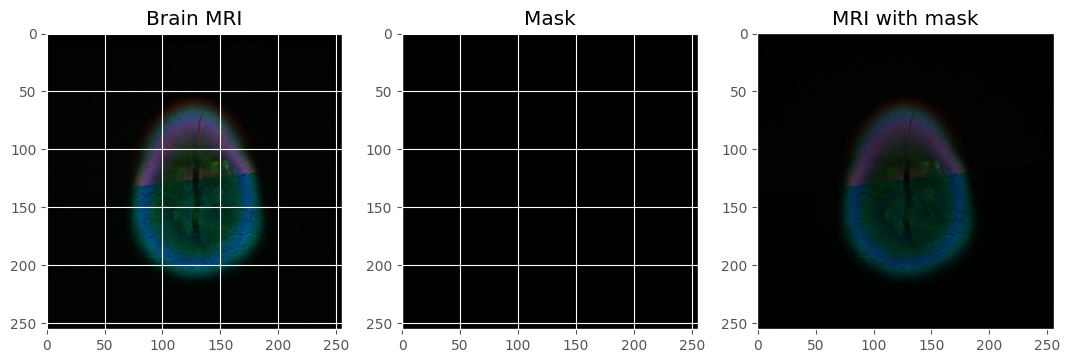

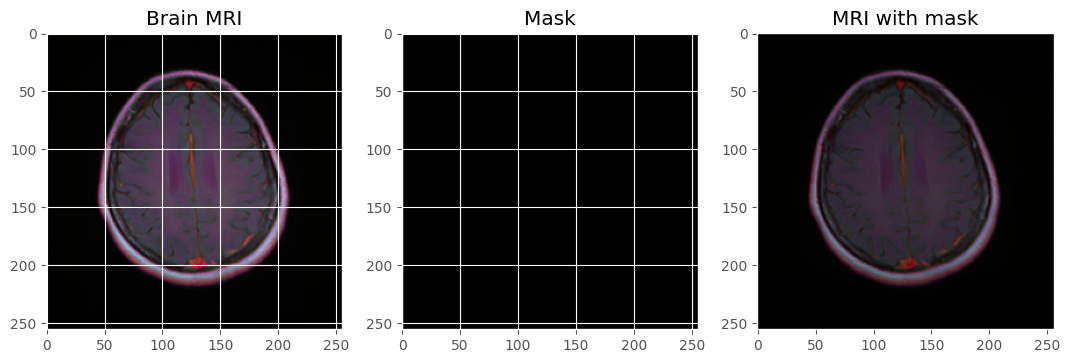

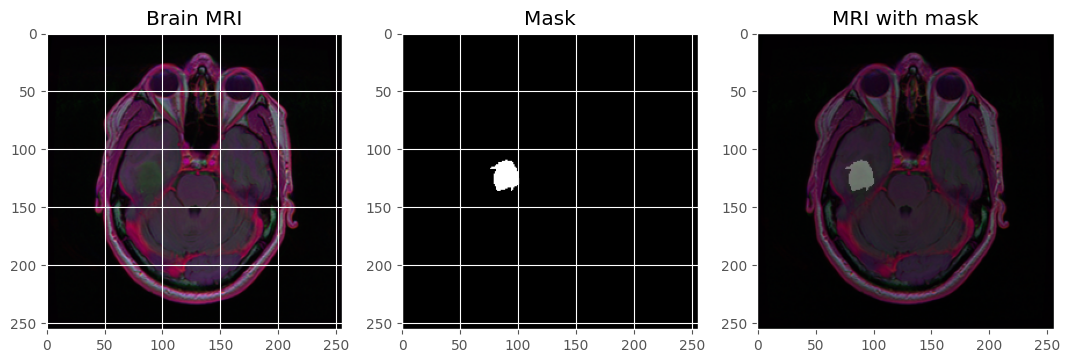

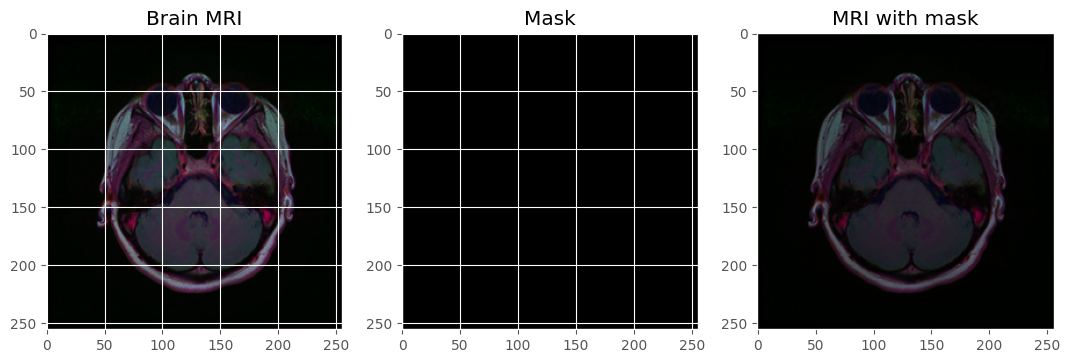

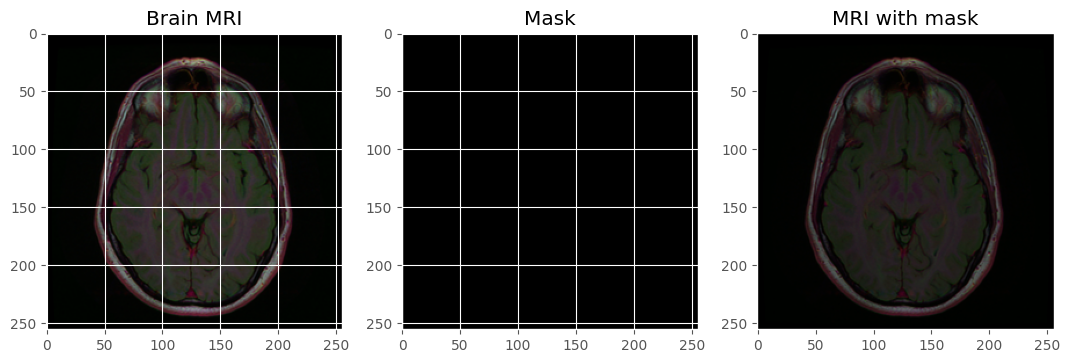

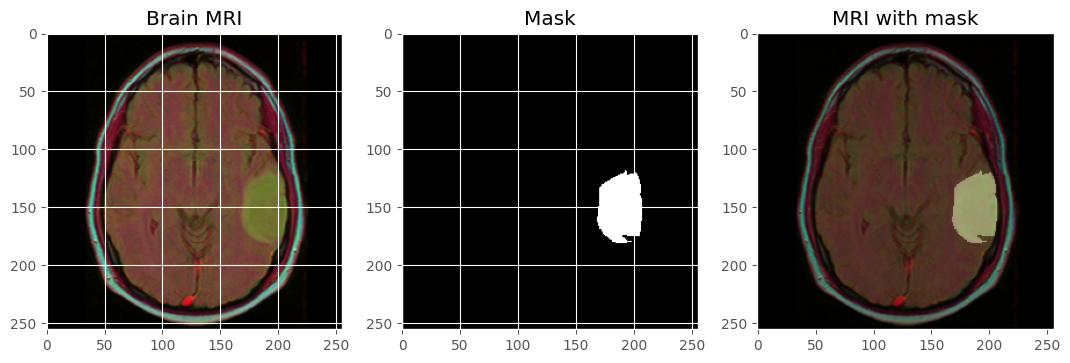

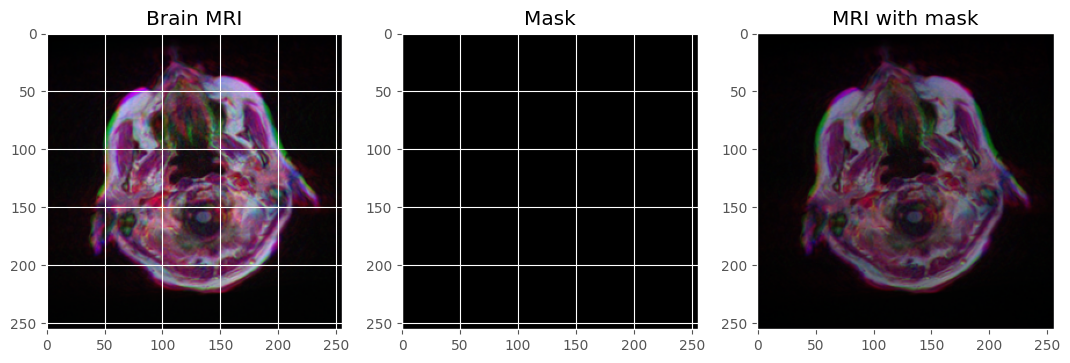

In [ ]:
for i in range(10):
    plotImages()

# Data Processing

In [ ]:
samples_df['image_path'] = '/kaggle/input/lgg-mri-segmentation/kaggle_3m/' + samples_df['directory'] + '/' + samples_df['images']
samples_df['mask_path'] = '/kaggle/input/lgg-mri-segmentation/kaggle_3m/' + samples_df['directory'] + '/' + samples_df['masks']

In [ ]:
samples_df.head(15)

,directory,images,masks,image_path,mask_path
0,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_56.tif,TCGA_DU_7010_19860307_56_mask.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_8.tif,TCGA_DU_7010_19860307_8_mask.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_34.tif,TCGA_DU_7010_19860307_34_mask.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_33.tif,TCGA_DU_7010_19860307_33_mask.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_43.tif,TCGA_DU_7010_19860307_43_mask.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
5,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_39.tif,TCGA_DU_7010_19860307_39_mask.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
6,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_7.tif,TCGA_DU_7010_19860307_7_mask.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
7,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_31.tif,TCGA_DU_7010_19860307_31_mask.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
8,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_6.tif,TCGA_DU_7010_19860307_6_mask.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
9,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_38.tif,TCGA_DU_7010_19860307_38_mask.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [ ]:
train, test = train_test_split(samples_df, test_size=0.3, random_state=42)

# Image Generator

In [ ]:
data_aug_dict = dict(rotation_range=0.4,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.02,
                    zoom_range=0.04,
                    vertical_flip=True)

# Train Generator

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255., **data_aug_dict)
mask_gen = ImageDataGenerator(rescale=1./255., **data_aug_dict)



train_image_gen = image_gen.flow_from_dataframe(dataframe=train,
                                                x_col='image_path',
                                                class_mode=None,
                                                batch_size=BATCH_SIZE,
                                                seed=42,
                                                target_size=(IMGHEIGHT, IMGWIDTH),
                                                color_mode='rgb')

train_mask_gen = image_gen.flow_from_dataframe(dataframe=train,
                                              class_mode=None,
                                              x_col='mask_path',
                                              batch_size=BATCH_SIZE,
                                              seed=42,
                                              target_size=(IMGHEIGHT, IMGWIDTH),
                                              color_mode='grayscale')

Found 2750 validated image filenames.
Found 2750 validated image filenames.


# Test Generator

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255.)
mask_gen = ImageDataGenerator(rescale=1./255.)

valid_image_gen = image_gen.flow_from_dataframe(dataframe=test, x_col='image_path', class_mode=None, batch_size=BATCH_SIZE, seed=42, target_size=(IMGHEIGHT, IMGWIDTH), color_mode='rgb')
valid_mask_gen = image_gen.flow_from_dataframe(dataframe=test, class_mode=None, x_col='mask_path', batch_size=BATCH_SIZE, seed=42, target_size=(IMGHEIGHT, IMGWIDTH), color_mode='grayscale')

Found 1179 validated image filenames.
Found 1179 validated image filenames.


In [ ]:
def dataIterator(image_gen, mask_gen):
    for img, mask in zip(image_gen, mask_gen):
        yield img, mask

In [ ]:
train_gen = dataIterator(train_image_gen, train_mask_gen)
valid_gen = dataIterator(valid_image_gen, valid_mask_gen)

# UNet Architecture

In [ ]:
STEP_SIZE_TRAIN = train_image_gen.n/BATCH_SIZE
STEP_SIZE_VALID = valid_image_gen.n/BATCH_SIZE

In [ ]:
def conv2dBlock(input_tensor, n_filters, kernel_size = 3, batchnorm = True):

    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

In [ ]:
STEP_SIZE_TRAIN = train_image_gen.n/BATCH_SIZE
STEP_SIZE_VALID = valid_image_gen.n/BATCH_SIZE

In [ ]:
def getUnet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):

    c1 = conv2dBlock(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2dBlock(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2dBlock(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2dBlock(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2dBlock(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    p5 = MaxPooling2D((2, 2))(c5)
    p5 = Dropout(dropout)(p5)

    c6 = conv2dBlock(p5, n_filters = n_filters * 32, kernel_size = 3, batchnorm = batchnorm)

    u6 = Conv2DTranspose(n_filters*16, (3, 3), strides=(2,2), padding='same')(c6)
    u6 = concatenate([u6, c5])
    u6 = Dropout(dropout)(u6)
    c7 = conv2dBlock(u6, n_filters*16, kernel_size = 3, batchnorm = batchnorm)

    u7 = Conv2DTranspose(n_filters*8, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u7 = concatenate([u7, c4])
    u7 = Dropout(dropout)(u7)
    c8 = conv2dBlock(u7, n_filters*8, kernel_size = 3, batchnorm = batchnorm)

    u8 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u8 = concatenate([u8, c3])
    u8 = Dropout(dropout)(u8)
    c9 = conv2dBlock(u8, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c9)
    u9 = concatenate([u9, c2])
    u9 = Dropout(dropout)(u9)
    c10 = conv2dBlock(u9, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    u10 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c10)
    u10 = concatenate([u10, c1])
    u10 = Dropout(dropout)(u10)
    c11 = conv2dBlock(u10, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c11)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
input_img1 = Input((IMG_HEIGHT, IMG_WIDTH, CHANNELS), name='img')
model = getUnet(input_img1, n_filters=16, dropout=0.2, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 16  448         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 224, 224, 16  64         ['conv2d_1[0][0]']               
 rmalization)                   )                                                             

In [ ]:
historyUNetv1 = model.fit(train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    batch_size=BATCH_SIZE,
                    epochs=20,
                    validation_data=valid_gen,
                   validation_steps=STEP_SIZE_VALID)

Epoch 1/20


2024-08-19 19:44:15.780106: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


85/85 [==============================] - 91s 908ms/step - loss: 0.6090 - accuracy: 0.8030 - val_loss: 0.5444 - val_accuracy: 0.9878
Epoch 2/20
85/85 [==============================] - 48s 560ms/step - loss: 0.3460 - accuracy: 0.9885 - val_loss: 0.3919 - val_accuracy: 0.9889
Epoch 3/20
85/85 [==============================] - 48s 563ms/step - loss: 0.2648 - accuracy: 0.9888 - val_loss: 0.2958 - val_accuracy: 0.9890
Epoch 4/20
85/85 [==============================] - 47s 550ms/step - loss: 0.1842 - accuracy: 0.9891 - val_loss: 0.2126 - val_accuracy: 0.9889
Epoch 5/20
85/85 [==============================] - 48s 562ms/step - loss: 0.1307 - accuracy: 0.9892 - val_loss: 0.1088 - val_accuracy: 0.9889
Epoch 6/20
85/85 [==============================] - 49s 573ms/step - loss: 0.0970 - accuracy: 0.9900 - val_loss: 0.0783 - val_accuracy: 0.9898
Epoch 7/20
85/85 [==============================] - 48s 565ms/step - loss: 0.0762 - accuracy: 0.9907 - val_loss: 0.0630 - val_accuracy: 0.9911
Epoch 8/20

In [ ]:
model.save('/kaggle/working/99UNetBTSegv1.hdf5')

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(historyUNetv1.history["loss"], label="loss", color=sns.xkcd_rgb['greenish teal'])
plt.plot(historyUNetv1.history["val_loss"], label="val_loss", color=sns.xkcd_rgb['amber'])
plt.plot( np.argmin(historyUNetv1.history["val_loss"]), np.min(historyUNetv1.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()
plt.show()

# Predictions

In [ ]:
eval_results = model.evaluate(valid_gen, steps=STEP_SIZE_VALID, verbose=1)

In [ ]:
for i in range(5):
    idx = np.random.randint(0, len(samples_df))

    imagePath = os.path.join('/kaggle/input/lgg-mri-segmentation/kaggle_3m/', samples_df['directory'].iloc[idx], samples_df['images'].iloc[idx])
    maskPath = os.path.join('/kaggle/input/lgg-mri-segmentation/kaggle_3m/', samples_df['directory'].iloc[idx], samples_df['masks'].iloc[idx])

    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)

    img = cv2.resize(image ,(IMGHEIGHT
                             , IMGWIDTH))
    img = img / 224
    img = img[np.newaxis, :, :, :]

    pred = model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,4,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')

    plt.subplot(1,4,2)
    plt.imshow(mask)
    plt.title('Original Mask')

    plt.subplot(1,4,3)
    plt.imshow(np.squeeze(pred))
    plt.title('Prediction')

    plt.subplot(1,4,4)
    plt.imshow(np.squeeze(pred) > 0.5)
    plt.title('BinaryPrediction')
    plt.show()

In [ ]:
def compute_iou(y_true, y_pred, threshold=0.5):

    y_pred_bin = (y_pred > threshold).astype(np.uint8)
    intersection = np.logical_and(y_true, y_pred_bin)
    union = np.logical_or(y_true, y_pred_bin)
    iou = np.sum(intersection) / np.sum(union)
    return iou

for i in range(5):
    idx = np.random.randint(0, len(samples_df))

    imagePath = os.path.join('/kaggle/input/lgg-mri-segmentation/kaggle_3m/', samples_df['directory'].iloc[idx], samples_df['images'].iloc[idx])
    maskPath = os.path.join('/kaggle/input/lgg-mri-segmentation/kaggle_3m/', samples_df['directory'].iloc[idx], samples_df['masks'].iloc[idx])

    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath, cv2.IMREAD_GRAYSCALE)

    img_resized = cv2.resize(image, (IMGWIDTH, IMGHEIGHT))
    img_resized = img_resized / 255.0  # Нормализация
    img_resized = img_resized[np.newaxis, :, :, :]

    pred = model.predict(img_resized)
    pred_resized = cv2.resize(pred[0, :, :, 0], (mask.shape[1], mask.shape[0]))

    mask_bin = (mask > 0).astype(np.uint8)
    pred_bin = (pred_resized > 0.5).astype(np.uint8)

    iou = compute_iou(mask_bin, pred_bin)

    plt.figure(figsize=(12, 12))
    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')

    plt.subplot(1, 4, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Original Mask')

    plt.subplot(1, 4, 3)
    plt.imshow(pred_resized, cmap='gray')
    plt.title('Prediction')

    plt.subplot(1, 4, 4)
    plt.imshow(pred_bin, cmap='gray')
    plt.title(f'Binary Prediction\nIoU: {iou:.4f}')

    plt.show()


In [ ]:
model.save('model.h5')